In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Usando dispositivo: {device}')

transform = transforms.Compose([transforms.ToTensor()])

#datos
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
valid_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

#lotes de 100
BATCH_SIZE = 100
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

Usando dispositivo: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 309kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.6MB/s]


In [ ]:
class Autoencoder_Conv(nn.Module):
    def __init__(self, n=64, p=0.1):
        super().__init__()
        self.n = n

        #encoder
        #28x28 -> n
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, n),
            nn.ReLU()
        )

        #decoder
        #n -> 28x28
        self.decoder = nn.Sequential(
            nn.Linear(n, 32 * 7 * 7),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() #para que los valores esten entre 0 y 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#modelo
model = Autoencoder_Conv(n=64, p=0.1).to(device)
loss_fn = nn.MSELoss() #error cuadrático medio
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
#función entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)

#función validación
def eval_loop(dataloader, model, loss_fn):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            loss = loss_fn(pred, X)
            valid_loss += loss.item()

    return valid_loss / len(dataloader)

In [ ]:
num_epochs = 50
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    t_loss = train_loop(train_loader, model, loss_fn, optimizer)
    v_loss = eval_loop(valid_loader, model, loss_fn)

    train_losses.append(t_loss)
    valid_losses.append(v_loss)

    print(f"Epoch {epoch+1:>2d} | Train Loss: {t_loss:.5f} | Valid Loss: {v_loss:.5f}")

    if v_loss < best_valid_loss:
        best_valid_loss = v_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'autoencoder_f5.pth') #guarda pesos
        print(f"modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Se detuvo en la época {epoch+1}")
            break

Epoch  1 | Train Loss: 0.03368 | Valid Loss: 0.01621
modelo guardado.
Epoch  2 | Train Loss: 0.01681 | Valid Loss: 0.01314
modelo guardado.
Epoch  3 | Train Loss: 0.01452 | Valid Loss: 0.01148
modelo guardado.
Epoch  4 | Train Loss: 0.01329 | Valid Loss: 0.01071
modelo guardado.
Epoch  5 | Train Loss: 0.01258 | Valid Loss: 0.01013
modelo guardado.
Epoch  6 | Train Loss: 0.01214 | Valid Loss: 0.00974
modelo guardado.
Epoch  7 | Train Loss: 0.01181 | Valid Loss: 0.00953
modelo guardado.
Epoch  8 | Train Loss: 0.01157 | Valid Loss: 0.00937
modelo guardado.
Epoch  9 | Train Loss: 0.01141 | Valid Loss: 0.00920
modelo guardado.
Epoch 10 | Train Loss: 0.01127 | Valid Loss: 0.00909
modelo guardado.
Epoch 11 | Train Loss: 0.01115 | Valid Loss: 0.00900
modelo guardado.
Epoch 12 | Train Loss: 0.01106 | Valid Loss: 0.00887
modelo guardado.
Epoch 13 | Train Loss: 0.01096 | Valid Loss: 0.00884
modelo guardado.
Epoch 14 | Train Loss: 0.01090 | Valid Loss: 0.00880
modelo guardado.
Epoch 15 | Train Los

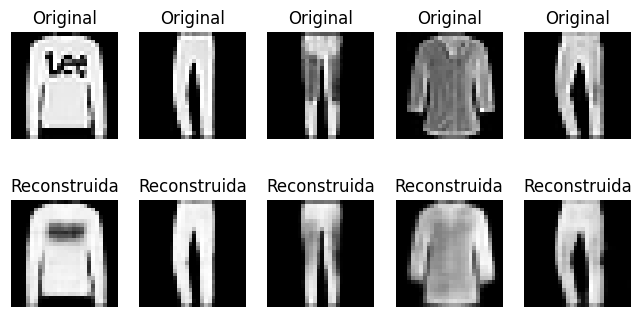

In [ ]:
model.eval()
figure = plt.figure(figsize=(8, 4))
cols, rows = 5, 2

dataiter = iter(valid_loader)
images, _ = next(dataiter)
images = images.to(device)
with torch.no_grad():
    outputs = model(images)

images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

for i in range(1, cols + 1):
    #imagen original
    figure.add_subplot(rows, cols, i)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap="gray")

    #reconstruida
    figure.add_subplot(rows, cols, i + cols)
    plt.title("Reconstruida")
    plt.axis("off")
    plt.imshow(outputs[i].squeeze(), cmap="gray")

plt.show()

In [ ]:
import copy
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

#clasificador
class Clasificador_Conv(nn.Module):
    def __init__(self, encoder_base, n=64, num_classes=10):
        super().__init__()
        #usamos el encoder del autoencoder
        self.encoder = encoder_base
        #para clasificar
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [ ]:
#CASO1 encoder preentrenado y entrenamineto conjunto
#CASO2 encoder preentrenado y entrenamiento solo clasificador
#CASO3 encoder sin preentrenar y entrenamineto conjunto
#CASO4 encoder sin preentrenar y entrenamiento solo clasificador

CASO = 4  #cambiar 1,2,3,4
encoder_copy = copy.deepcopy(model.encoder)
# Reiniciar pesos si es Caso 3 o 4
if CASO in [3, 4]:
    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
    encoder_copy.apply(init_weights)

# Congelar si es Caso 2 o 4
if CASO in [2, 4]:
    for param in encoder_copy.parameters():
        param.requires_grad = False

# Definición del modelo y optimizador
model_clf = Clasificador_Conv(encoder_copy, n=64).to(device)
loss_fn = nn.CrossEntropyLoss()

# Solo optimizamos los parámetros que no están congelados
params = [p for p in model_clf.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3)

In [ ]:
num_epochs_clf = 15
train_losses_clf = []
valid_losses_clf = []
valid_acc_clf = []

for epoch in range(num_epochs_clf):
    model_clf.train()
    running_loss = 0

    #entrenamiento
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model_clf(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    #validación
    model_clf.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)
            pred = model_clf(X)
            loss = loss_fn(pred, y)
            valid_loss += loss.item()

            #precisión
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    accuracy = correct / total

    #
    train_losses_clf.append(avg_train_loss)
    valid_losses_clf.append(avg_valid_loss)
    valid_acc_clf.append(accuracy)

    print(f"Epoch {epoch+1:>2d} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Acc: {accuracy:.2%}")


Epoch  1 | Train Loss: 2.2356 | Valid Loss: 2.1717 | Acc: 56.23%
Epoch  2 | Train Loss: 2.1155 | Valid Loss: 2.0580 | Acc: 61.32%
Epoch  3 | Train Loss: 2.0148 | Valid Loss: 1.9602 | Acc: 64.37%
Epoch  4 | Train Loss: 1.9326 | Valid Loss: 1.8756 | Acc: 62.86%
Epoch  5 | Train Loss: 1.8640 | Valid Loss: 1.8031 | Acc: 62.86%
Epoch  6 | Train Loss: 1.8071 | Valid Loss: 1.7396 | Acc: 64.51%
Epoch  7 | Train Loss: 1.7608 | Valid Loss: 1.6844 | Acc: 63.45%
Epoch  8 | Train Loss: 1.7167 | Valid Loss: 1.6358 | Acc: 63.84%
Epoch  9 | Train Loss: 1.6878 | Valid Loss: 1.5933 | Acc: 64.28%
Epoch 10 | Train Loss: 1.6565 | Valid Loss: 1.5542 | Acc: 64.96%
Epoch 11 | Train Loss: 1.6271 | Valid Loss: 1.5198 | Acc: 65.08%
Epoch 12 | Train Loss: 1.6063 | Valid Loss: 1.4912 | Acc: 65.14%
Epoch 13 | Train Loss: 1.5863 | Valid Loss: 1.4633 | Acc: 65.27%
Epoch 14 | Train Loss: 1.5732 | Valid Loss: 1.4393 | Acc: 65.48%
Epoch 15 | Train Loss: 1.5567 | Valid Loss: 1.4146 | Acc: 65.57%


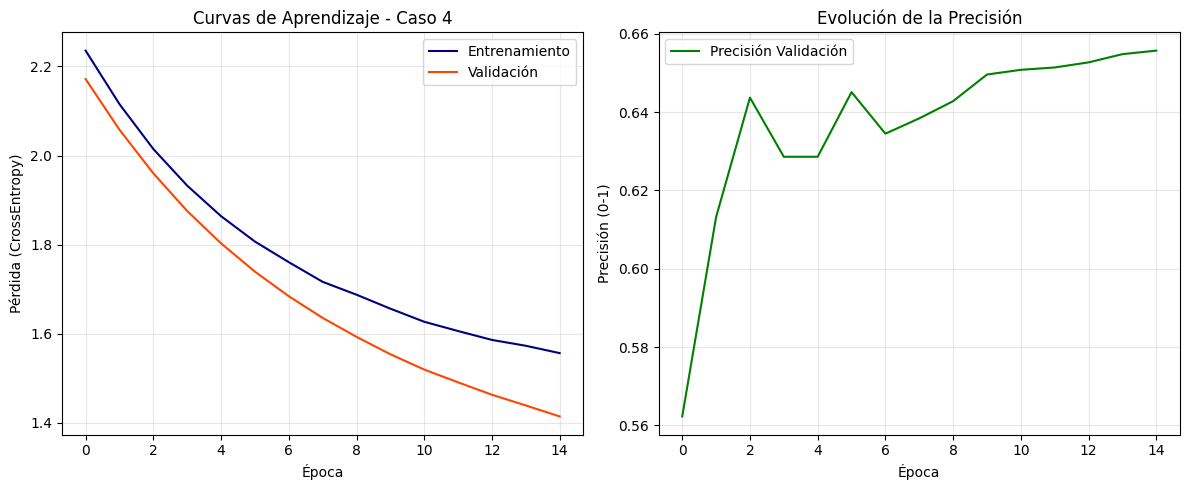

In [ ]:
plt.figure(figsize=(12, 5))

#pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses_clf, label='Entrenamiento', color='navy')
plt.plot(valid_losses_clf, label='Validación', color='orangered')
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title(f"Curvas de Aprendizaje - Caso {CASO}")
plt.legend()
plt.grid(True, alpha=0.3)

#precisión
plt.subplot(1, 2, 2)
plt.plot(valid_acc_clf, label='Precisión Validación', color='green')
plt.xlabel("Época")
plt.ylabel("Precisión (0-1)")
plt.title("Evolución de la Precisión")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

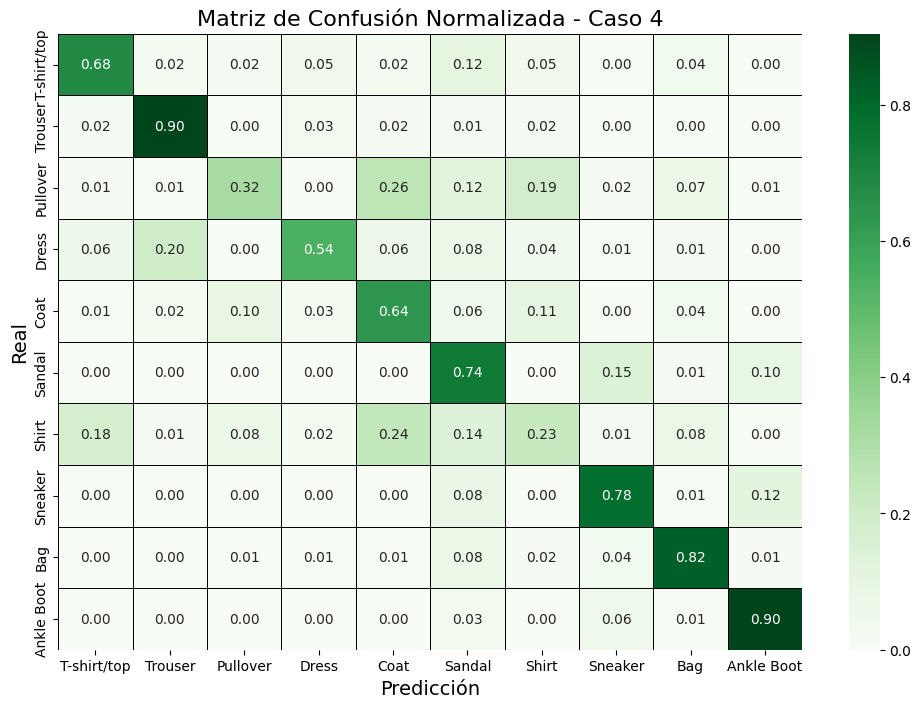

In [ ]:
y_pred = []
y_true = []

model_clf.eval()

with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        outputs = model_clf(X)
        predicted = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(predicted)
        y_true.extend(y.numpy())

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

#matriz
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis],
                     index=classes, columns=classes)

plt.figure(figsize=(12, 8))
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="Greens", linewidths=0.5, linecolor="black")
plt.xlabel("Predicha", fontsize=14)
plt.ylabel("Observada", fontsize=14)
plt.title(f"Matriz de Confusión Normalizada - Caso {CASO}", fontsize=16)
plt.show()